# Arewa Data Science Academy
## Deep Learning Cohort2.0
### Name: Abdulazeez Ahmad
### Email: azeezahmad518@gmail.com
### Title: Week 3 Solution

In [104]:
# Import Pytorch
import torch

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# Setup random seed
RANDOM_SEED = 42

cuda


## 1. Make a binary classification dataset with Scikit-Learn's make_moons() function.

In [105]:
from sklearn.datasets import make_moons

num_samples = 1000
noise_level = 0.075

# Create dataset
X, y = make_moons(n_samples=num_samples, noise=noise_level, random_state=RANDOM_SEED)

print(f"first 10 samples of X: {X[:10]}")
print(f"first 10 samples of y: {y[:10]}")

first 10 samples of X: [[-0.03642046  0.42519235]
 [ 1.00435868 -0.43903211]
 [ 0.88597534 -0.31567332]
 [ 0.33310708 -0.42285289]
 [-0.83768234  0.5328218 ]
 [ 0.60150447 -0.28187264]
 [ 0.28949097 -0.20411985]
 [-0.04124126  0.46237088]
 [ 1.61217884 -0.29556498]
 [ 0.69605441  0.83299371]]
first 10 samples of y: [1 1 1 1 0 1 1 1 1 0]


In [106]:
# Turn data into a DataFrame
import pandas as pd
moons_df = pd.DataFrame({"X0": X[:, 0], "X1": X[:, 1], "y": y})
moons_df.head()

,X0,X1,y
0,-0.036420,0.425192,1
1,1.004359,-0.439032,1
2,0.885975,-0.315673,1
3,0.333107,-0.422853,1
4,-0.837682,0.532822,0


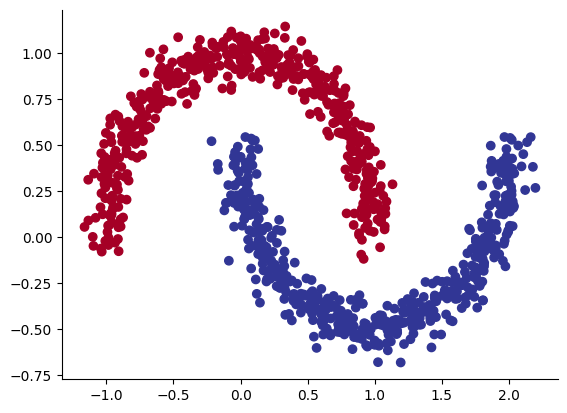

In [107]:
# Visualize the data on a scatter plot
import matplotlib.pyplot as plt

plt.scatter(moons_df["X0"], moons_df["X1"], c=moons_df["y"], cmap=plt.cm.RdYlBu)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show()

In [108]:
# Turn data into tensors of dtype float
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split the data into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.

In [109]:
from torch import nn

class MoonModelV0(nn.Module):
    def __init__(self, in_features, out_features, hidden_units):
        super().__init__()

        self.layer1 = nn.Linear(in_features=in_features,
                                 out_features=hidden_units)
        self.layer2 = nn.Linear(in_features=hidden_units,
                                 out_features=hidden_units)
        self.layer3 = nn.Linear(in_features=hidden_units,
                                out_features=out_features)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model_0 = MoonModelV0(in_features=2,
                      out_features=1,
                      hidden_units=10).to(device)
model_0

MoonModelV0(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

## 3. Setup a binary classification compatible loss function and optimizer to use when training the model built in 2.

In [110]:
# Setting up a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setting up an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [111]:
# What's coming out of our model?

# logits (raw outputs of model)
print("Logits:")
print(model_0(X_train.to(device)[:10]).squeeze())

# Prediction probabilities
print("Pred probs:")
print(torch.sigmoid(model_0(X_train.to(device)[:10]).squeeze()))

# Prediction probabilities
print("Pred labels:")
print(torch.round(torch.sigmoid(model_0(X_train.to(device)[:10]).squeeze())))

Logits:
tensor([0.2289, 0.1191, 0.1485, 0.1443, 0.1044, 0.1395, 0.1100, 0.1005, 0.1594,
        0.1066], device='cuda:0', grad_fn=<SqueezeBackward0>)
Pred probs:
tensor([0.5570, 0.5297, 0.5371, 0.5360, 0.5261, 0.5348, 0.5275, 0.5251, 0.5398,
        0.5266], device='cuda:0', grad_fn=<SigmoidBackward0>)
Pred labels:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0',
       grad_fn=<RoundBackward0>)


In [112]:
# Installing torchmetrics

!pip -q install torchmetrics

In [113]:
# Calculating Accuracy
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=2).to(device) # send accuracy function to device
acc_fn

MulticlassAccuracy()

In [114]:
torch.manual_seed(RANDOM_SEED)

epochs=1000

# Send data to the device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through the data
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  # print(y_logits[:5]) # model raw outputs are "logits"
  y_pred_probs = torch.sigmoid(y_logits)
  y_pred = torch.round(y_pred_probs)

  # 2. Calculaute the loss
  loss = loss_fn(y_logits, y_train)
  acc = acc_fn(y_pred, y_train.int())
  # 3. Zero the gradients
  optimizer.zero_grad()

  # 4. Loss backward (perform backpropagation)
  loss.backward()

  # 5. Step the optimizer (gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # 2. Caculate the loss/acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test.int())

  # Printing out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")


Epoch: 0 | Loss: 0.70 Acc: 0.50 | Test loss: 0.70 Test acc: 0.50
Epoch: 100 | Loss: 0.38 Acc: 0.83 | Test loss: 0.39 Test acc: 0.81
Epoch: 200 | Loss: 0.24 Acc: 0.88 | Test loss: 0.24 Test acc: 0.89
Epoch: 300 | Loss: 0.21 Acc: 0.91 | Test loss: 0.21 Test acc: 0.90
Epoch: 400 | Loss: 0.19 Acc: 0.92 | Test loss: 0.19 Test acc: 0.90
Epoch: 500 | Loss: 0.16 Acc: 0.93 | Test loss: 0.16 Test acc: 0.92
Epoch: 600 | Loss: 0.13 Acc: 0.94 | Test loss: 0.13 Test acc: 0.95
Epoch: 700 | Loss: 0.10 Acc: 0.96 | Test loss: 0.09 Test acc: 0.98
Epoch: 800 | Loss: 0.07 Acc: 0.98 | Test loss: 0.06 Test acc: 0.99
Epoch: 900 | Loss: 0.05 Acc: 0.99 | Test loss: 0.04 Test acc: 1.00


## 5. Make predictions with your trained model and plot them using the plot_decision_boundary() function created in this notebook.

In [115]:
# Plot the model predictions

import numpy as np

# TK - this could go in the helper_functions.py and be explained there
def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

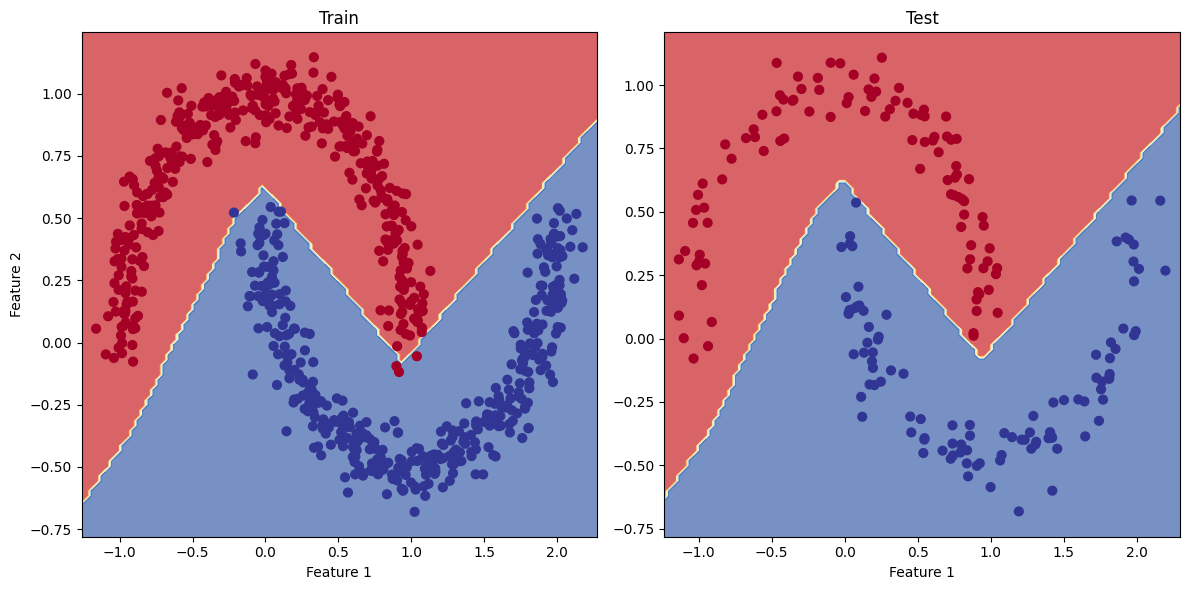

In [93]:
plt.figure(figsize=(12, 6))

# Train Decision Boundary
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.xlabel("Feature 1")  # Optional: Label axes for clarity
plt.ylabel("Feature 2")

# Test Decision Boundary
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)
plt.xlabel("Feature 1")

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


## 6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.

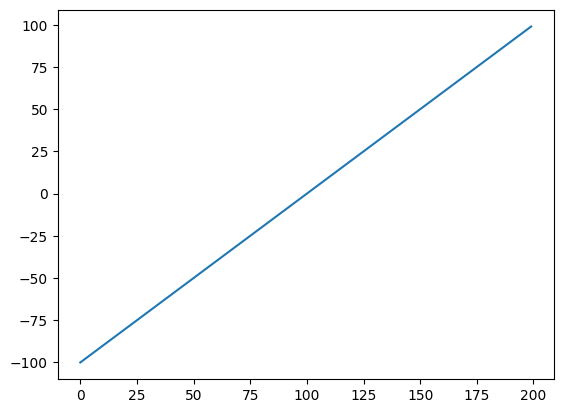

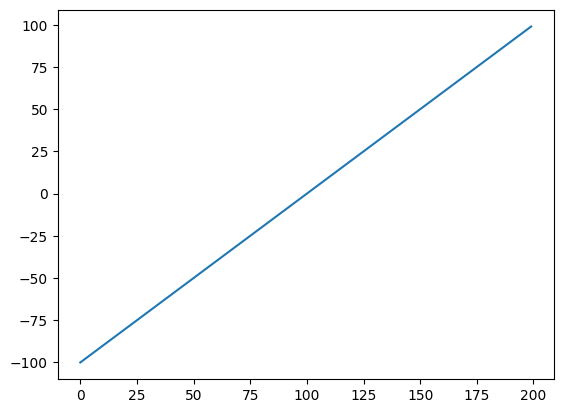

In [116]:
tensor_A = torch.arange(-100, 100, 1)
plt.plot(tensor_A)

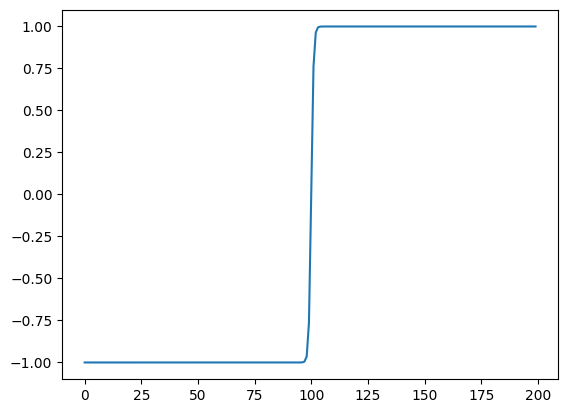

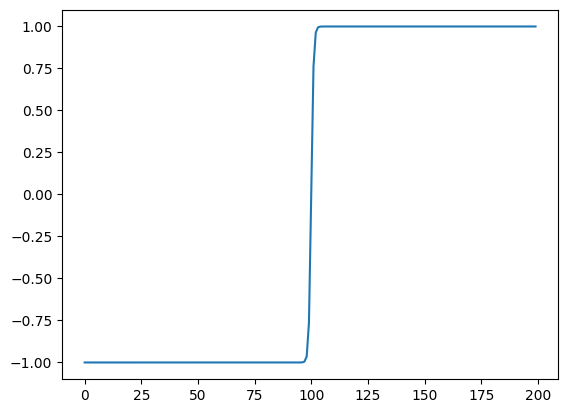

In [117]:
plt.plot(torch.tanh(tensor_A))

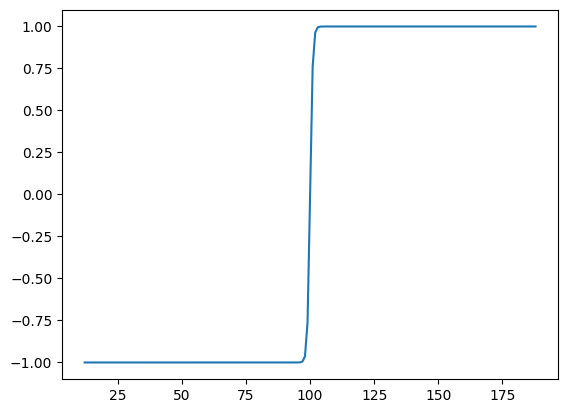

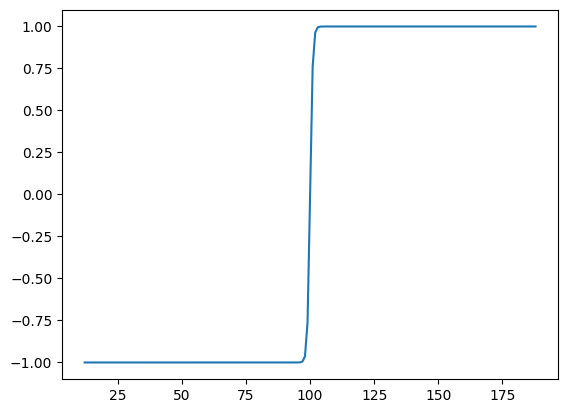

In [118]:
def tanh(x):
  # Source - https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh
  return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

plt.plot(tanh(tensor_A))

## 7. Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code).

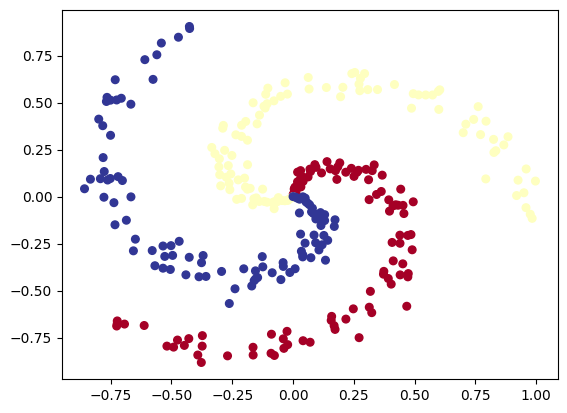

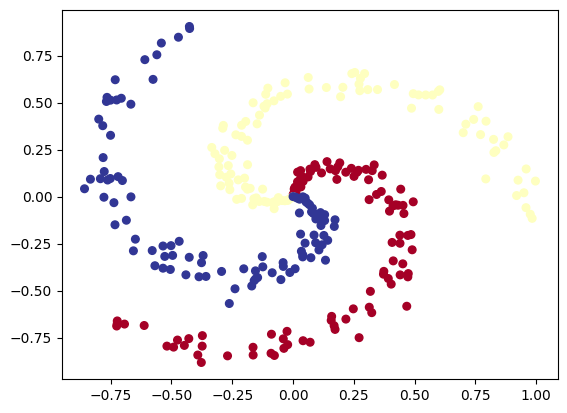

In [119]:
# Code for creating a spiral dataset from CS231n
import numpy as np
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.RdYlBu)
plt.show()

In [120]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
len(X_train), len(X_test), len(y_train), len(y_test)


(240, 60, 240, 60)

(240, 60, 240, 60)

In [121]:
# Let's calculate the accuracy for when we fit our model
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=3).to(device) # send accuracy function to device
acc_fn


MulticlassAccuracy()

MulticlassAccuracy()

In [122]:
# Prepare device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

class SpiralModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(in_features=2, out_features=10)
    self.linear2 = nn.Linear(in_features=10, out_features=10)
    self.linear3 = nn.Linear(in_features=10, out_features=3)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.linear3(self.relu(self.linear2(self.relu(self.linear1(x)))))

model_1 = SpiralModel().to(device)
model_1

SpiralModel(
  (linear1): Linear(in_features=2, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=10, bias=True)
  (linear3): Linear(in_features=10, out_features=3, bias=True)
  (relu): ReLU()
)

SpiralModel(
  (linear1): Linear(in_features=2, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=10, bias=True)
  (linear3): Linear(in_features=10, out_features=3, bias=True)
  (relu): ReLU()
)

In [123]:
# Setup data to be device agnostic
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
print(X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype)

# Print out untrained model outputs
print("Logits:")
print(model_1(X_train)[:10])

print("Pred probs:")
print(torch.softmax(model_1(X_train)[:10], dim=1))

print("Pred labels:")
print(torch.softmax(model_1(X_train)[:10], dim=1).argmax(dim=1))

torch.float32 torch.float32 torch.int64 torch.int64
Logits:
tensor([[-0.2160, -0.0600,  0.2256],
        [-0.2020, -0.0530,  0.2257],
        [-0.2223, -0.0604,  0.2384],
        [-0.2174, -0.0555,  0.2826],
        [-0.2201, -0.0502,  0.2792],
        [-0.2195, -0.0565,  0.2457],
        [-0.2212, -0.0581,  0.2440],
        [-0.2251, -0.0631,  0.2354],
        [-0.2116, -0.0548,  0.2336],
        [-0.2170, -0.0552,  0.2842]], device='cuda:0',
       grad_fn=<SliceBackward0>)
Pred probs:
tensor([[0.2685, 0.3139, 0.4176],
        [0.2707, 0.3142, 0.4151],
        [0.2659, 0.3126, 0.4215],
        [0.2615, 0.3074, 0.4311],
        [0.2609, 0.3092, 0.4299],
        [0.2653, 0.3123, 0.4224],
        [0.2653, 0.3123, 0.4224],
        [0.2659, 0.3127, 0.4214],
        [0.2681, 0.3136, 0.4184],
        [0.2614, 0.3072, 0.4314]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Pred labels:
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
torch.float32 torch.float32 torch.int64 torch.int64


In [124]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.02)

In [125]:
# Build a training loop for the model
epochs = 1000

# Loop over data
for epoch in range(epochs):
  ## Training
  model_1.train()
  # 1. forward pass
  y_logits = model_1(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # 2. calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = acc_fn(y_pred, y_train)

  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. loss backwards
  loss.backward()

  # 5. optimizer step step step
  optimizer.step()

  ## Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    # 2. Caculate loss and acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test)

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 1.12 Acc: 0.32 | Test loss: 1.10 Test acc: 0.37
Epoch: 100 | Loss: 0.45 Acc: 0.78 | Test loss: 0.53 Test acc: 0.68
Epoch: 200 | Loss: 0.12 Acc: 0.96 | Test loss: 0.09 Test acc: 0.98
Epoch: 300 | Loss: 0.07 Acc: 0.98 | Test loss: 0.02 Test acc: 1.00
Epoch: 400 | Loss: 0.05 Acc: 0.98 | Test loss: 0.01 Test acc: 1.00
Epoch: 500 | Loss: 0.04 Acc: 0.99 | Test loss: 0.01 Test acc: 1.00
Epoch: 600 | Loss: 0.03 Acc: 0.99 | Test loss: 0.01 Test acc: 1.00
Epoch: 700 | Loss: 0.03 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch: 800 | Loss: 0.02 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch: 900 | Loss: 0.02 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch: 0 | Loss: 1.12 Acc: 0.32 | Test loss: 1.10 Test acc: 0.37
Epoch: 100 | Loss: 0.45 Acc: 0.78 | Test loss: 0.53 Test acc: 0.68
Epoch: 200 | Loss: 0.12 Acc: 0.96 | Test loss: 0.09 Test acc: 0.98
Epoch: 300 | Loss: 0.07 Acc: 0.98 | Test loss: 0.02 Test acc: 1.00
Epoch: 400 | Loss: 0.05 Acc: 0.98 | Test loss: 0.01 Test acc: 1.00

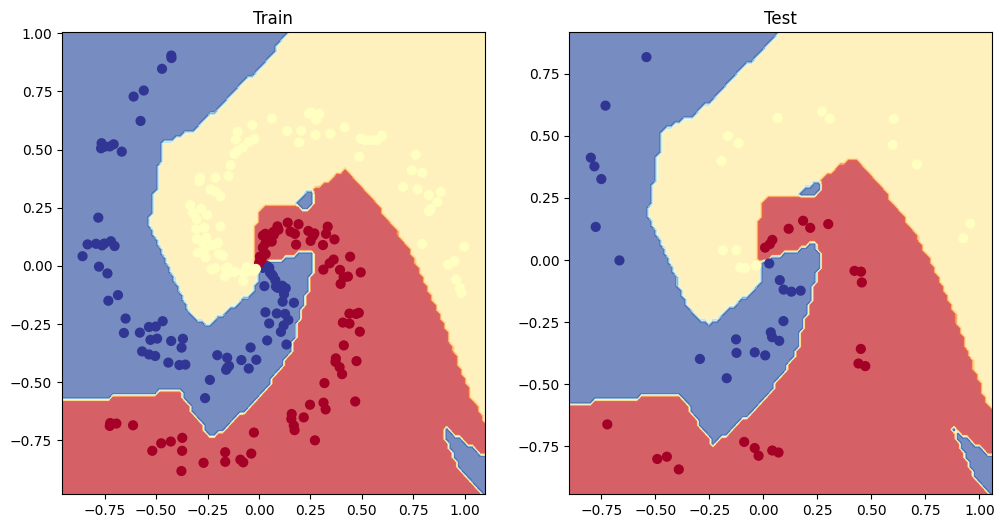

In [126]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)
